In [1]:
import pandas as pd
import numpy as np
import yaml
import os
from pathlib import Path


def load_file(path):
  with open(path, "r") as f:
    return yaml.load(f, Loader=yaml.FullLoader)

dir_files = os.path.join(os.path.dirname("__file__"), "results")
files = os.listdir(dir_files)
sols = [load_file(Path(dir_files,  f)) for f in files if f.endswith("_sol.yml")]


In [13]:
from itertools import chain
import jmespath


rows = []
for e in chain.from_iterable(sols):
    rows.append({
        "configuration": e.get("configuration"),
        "model": e.get("model"),
        "obj": jmespath.search("solution.obj", e),
        "time": e.get("time"),
    })

df_sols = pd.DataFrame(rows)
df_sols

,configuration,model,obj,time
0,Atlantis_BB,models/model/windfarm01.mzn,NaN,NaN
1,Atlantis_BB,models/model/windfarm02.mzn,NaN,NaN
2,Gecode_BB_90,models/model/windfarm02.mzn,257028672.0,0.535
3,Gecode_BB_90,models/model/windfarm02.mzn,257045392.0,0.662
4,Gecode_BB_90,models/model/windfarm02.mzn,257287046.0,0.672
...,...,...,...,...
518,Gecode_BB,models/model/windfarm02.mzn,252875342.0,810.110
519,Gecode_BB,models/model/windfarm02.mzn,252875413.0,810.193
520,Gecode_BB,models/model/windfarm02.mzn,252876208.0,835.586
521,Gecode_BB,models/model/windfarm02.mzn,252877000.0,860.776


In [23]:
import pandas as pd

df_orgs = pd.read_csv(Path(dir_files, "org_obj.csv"))
df_orgs['time'] = df_orgs['time'].astype(float) / 1000  # convert ms to s
df_orgs['obj'] = (df_orgs['obj'].astype(float) * 1000).round()
df_orgs['model'] = 'turbine_distribution'
df_orgs['configuration'] = 'turbine_distribution'

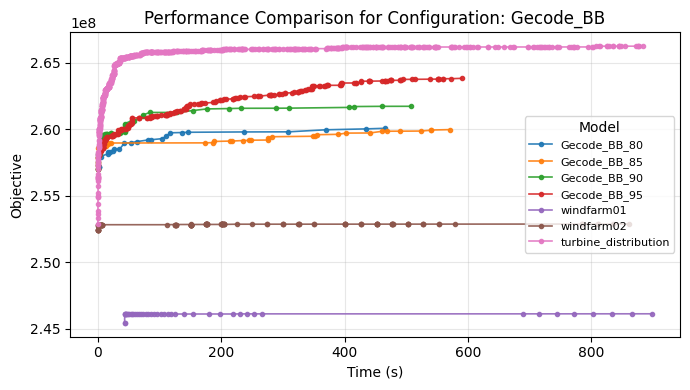

In [29]:
import matplotlib.pyplot as plt

# Filter dataframe for the desired configuration
df_cfg = df_sols[df_sols["configuration"].str.contains("Gecode_BB")].copy()
df_cfg.loc[df_cfg['configuration'] == 'Gecode_BB', 'configuration'] = 'Gecode_BB_' + df_cfg.loc[df_cfg['configuration'] == 'Gecode_BB', 'model'].str.extract(r'\/(.*)\.mzn', expand=False)
df_cfg = pd.concat([df_cfg, df_orgs[['configuration', 'obj', 'time']]], ignore_index=True)
df_cfg = df_cfg[df_cfg["time"] <= 900].copy()  # Filter out runs that exceed 15 minutes
# Plot obj vs time for each model under the same configuration
fig, ax = plt.subplots(figsize=(7, 4))
for model, dfm in df_cfg.groupby("configuration"):
    dfm = dfm.sort_values("time")
    ax.plot(dfm.time, dfm.obj, marker="o", ms=3, linewidth=1.2, label=Path(model).name, alpha=0.9)
ax.set_title(f"Performance Comparison for Configuration: {cfg}")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Objective")
ax.legend(title="Model", fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()

In [20]:
import re
from itertools import chain
stats = [
        {**load_file(Path(dir_files,  f)), 'path': f}
        for f in files if re.match(r"1_Gecode_BB_LNS_\d{0,3}_stats.yml", f)]
# stats[0].get("restarts")


rows = []
for e in stats:
    rows.append({
        "restart_scale": int(re.search(r"1_Gecode_BB_LNS_(\d{0,3})_stats.yml", e.get("path")).group(1)),
        "restarts": e.get("restarts"),
        "objective": -e.get("objective"),
        "solutions": e.get("solutions"),
    })

df_sols = pd.DataFrame(rows)
df_sols['diff_obj'] = df_sols['objective'] - df_sols['objective'].min()
print(df_sols.sort_values("restart_scale").to_markdown(index=False, floatfmt='.0f'))

|   restart_scale |   restarts |   objective |   solutions |   diff_obj |
|----------------:|-----------:|------------:|------------:|-----------:|
|               1 |  311338364 |   257303682 |          13 |     202391 |
|              26 |   23622316 |   257299200 |          12 |     197909 |
|              51 |    2100668 |   257303682 |           9 |     202391 |
|              76 |    1313633 |   257369852 |           6 |     268561 |
|             101 |    1141612 |   257287600 |           5 |     186309 |
|             126 |     715293 |   257295172 |          15 |     193881 |
|             151 |   13542343 |   257340251 |           9 |     238960 |
|             176 |     517989 |   257145118 |           6 |      43827 |
|             201 |     542759 |   257101291 |           5 |          0 |
|             226 |     441379 |   257342646 |           5 |     241355 |


In [23]:
import re
from itertools import chain
stats = [
        {**load_file(Path(dir_files,  f)), 'path': f}
        for f in files if re.match(r"1_Gecode_BB_LNS_\d{1,3}_\d{1,3}_stats.yml", f)]


rows = []
for e in stats:
    rows.append({
        "restart_scale": int(re.search(r"1_Gecode_BB_LNS_\d{0,3}_(\d{0,3})_stats.yml", e.get("path")).group(1)),
        "n": int(re.search(r"1_Gecode_BB_LNS_(\d{0,3})_\d{0,3}_stats.yml", e.get("path")).group(1)),
        "restarts": e.get("restarts"),
        "objective": -e.get("objective"),
        "solutions": e.get("solutions"),
    })

df_sols = pd.DataFrame(rows)
df_sols
# df_sols['diff_obj'] = df_sols['objective'] - df_sols['objective'].min()
# print(df_sols.sort_values("restart_scale").to_markdown(index=False, floatfmt='.0f'))

""


,restart_scale,restarts,objective,solutions,diff_obj
4,201,542759,257101291,5,0
2,176,517989,257145118,6,43827
3,101,1141612,257287600,5,186309
1,126,715293,257295172,15,193881
9,26,23622316,257299200,12,197909
6,1,311338364,257303682,13,202391
8,51,2100668,257303682,9,202391
0,151,13542343,257340251,9,238960
5,226,441379,257342646,5,241355
7,76,1313633,257369852,6,268561
